# Simulation numérique – ProgFest 2025
---
Par Arthur Légaré, le 5 mars 2025.

*Le masculin est utilisé pour alléger le texte.*

# Pourquoi simuler en physique?
---

Curieux de nature, le physicien est porté à expérimenter avec toutes sortes de cossins à sa disposition. Toutefois, avec la maîtrise du langage mathématique, sa curiosité vient généralement à bout des expériences immédiatement accessibles : il devient donc urgent d'agrandir le carré de sable!

Venons-y : la physique comporte son lot de phénomènes qui sont décrits par des équations complexes, souvent difficiles, voire impossibles, à résoudre analytiquement. C'est là que la simulation numérique entre en jeu, notamment pour :
1) explorer des systèmes trop complexes pour admettre une solution exacte;
2) visualiser des dynamiques évolutives et leurs comportements émergents;
3) tester des hypothèses et comparer avec des résultats expérimentaux.

Certains puristes pourraient y voir là les contours d'une sacrification de la physmath sur l'autel de la *force brute*. Mais attention : l'usage des simulations ne relègue pas aux oubliettes la physmath. Au contraire, nous verrons plutôt que cette dernière demeure l'outil privilégié pour affuter notre intuition, guidant ainsi nos explorations numériques et facilitant l'interprétation des résultats.


# 1. Plan de match
---

Nous verrons deux exemples de simulations numériques portant sur des sujets variés. Au terme de cet atelier, nous devrions être en mesure de mettre sur pied une recette pour simuler avec succès (voir annexe Z).

**a) Échanges thermiques dans un bâtiment** – Comparaison entre différentes stratégies de chauffage.

**b) Modèle d’activité neuronale** – Quantification de la ressemblance à la structure biologique observée.


# 2. Comment utiliser ce notebook
---
* Chaque simulation sera introduite par une brève présentation du problème et des équations associées.

* Le code principal est externalisé dans des fichiers Python (.py), améliorant la modularité du code. Ceci facilite ainsi l'exploration approfondie et l'implémentation de nouvelles simulations!

In [4]:
# Importons quelques librairies utiles.
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
import copy
import collections
from tqdm import tqdm
import matplotlib.pyplot as plt
import inc.functions as fc
import os
import time
import scipy as sp
import random

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 16

# 3.1 Échanges thermiques dans un bâtiment
---

### Problématique : mon coloc a l'habitude de descendre son chauffage au minimum et de fermer sa porte à son départ. Place au débat!
Quel est le scénario de chauffage est le **moins énergivore** : une désactivation du radiateur pour la journée ou une légère diminution de la température cible? Fort de notre intuition, nous savons qu'il faut minimiser l'énergie associée au chauffage.
$$
\text{À minimiser : } E_{\mathrm{chauffage}} = \int_{t_i}^{t_f} P_{\mathrm{radiateur}}(\tau)\text{d}\tau.
$$

<img src="inc/radiateur_off.png" width=1000 height=450 />


### Hypothèses
1) **Loi de Fourier** pour la conduction de chaleur,
$
\frac{\text{d}U(t)}{\text{d}t} = \frac{\kappa A}{d}\Delta T,
$
 est le mode dominant de transfert thermique.

2) **Gaz parfait** : l'énergie interne,
$
\text{d}U = nC_v \text{d}T,
$
ne dépend que de la température de l'air.

3) **Temps de relaxation** thermique : le temps que prend une pièce pour uniformiser sa température est négligeable comparativement au temps caractéristique des transferts thermiques entre pièces, si bien que
$
\tau_{\mathrm{relax}} \ll \tau_{\mathrm{transfert}},
$
ce qui permet de désigner la température d'une pièce $i$ simplement par $T_i(t)$.

4) On considère qu'aucun échange d'air n'a lieu entre les pièces et que la quantité initiale est donc confinée à chaque pièce.



### Mathématisation du problème


En combinant l'expression de variation d'énergie interne d'un gaz parfait,
$$
\text{d}U = nC_v \text{d}T,
$$
et la loi de Fourier pour la conduction thermique,
$$
\frac{\text{d}U}{\text{d}t} = \frac{\kappa A}{d}\Delta T \Longleftrightarrow \text{d}U(t)  = \frac{\kappa A}{d}\Delta T\text{d}t,
$$
nous obtenons
$$
\text{d}U = \text{d}U \implies nC_v \text{d}T(t) = \frac{\kappa A}{d}\Delta T(t) \text{d}t \Longleftrightarrow \boxed{nC_v \frac{\text{d}T(t)}{\text{d}t} = \frac{\kappa A}{d}\Delta T(t)}.
$$
Au passage, il est intéressant de remarquer que cette relation est **équivalente à la loi de refroidissement des corps**, formulée par Newton en 1701 [6].

En ce qui nous concerne, comme le taux de variation de température d'une pièce $i$ causé par le transfert thermique avec la pièce $j$ est proportionnel à la différence $\Delta T_{ij}(t) \equiv -(T_i(t)-T_j(t))$, on obtient
$$
n_iC_v \frac{\text{d}T_i(t)}{\text{d}t} = -\sum_{j\neq i} \underbrace{\frac{\kappa_{ij} A_{ij}}{d_{ij}}}_{\equiv k_{ij}}\Big(T_i(t) - T_j(t)\Big),
$$
où il faut sommer sur les $j\in\{1,...,N\}\backslash \{i\}$ autres pièces, qui agissent à titre de "tributaires" thermiques.
Nous ne sommons pas sur $j=i$ étant donné qu'on n'assume aucune conductivité de la pièce $i$ avec elle-même : $k_{ii} = 0 \; \forall i \in \mathbb{N}$. La diagonale de la matrice d'adjacence est donc nulle, ce qui nécessite le facteur $(1-\delta_{ij})$, de telle sorte que
$$
\boxed{n_iC_v \frac{\text{d}T_i(t)}{\text{d}t}  = -\sum_{j=1}^N k_{ij} \Big(T_i(t) - T_j(t)\Big) (1-\delta_{ij}) }.
$$
Cette situation correspond bien à celle d'un bâtiment de $N$ pièces, lesquelles présentent des conductivités thermiques encapsulées par la matrice d'adjacence
$$
K = \left [ k_{ij}\right ].
$$

#### Exemple de matrice d'adjacence $A=\left[a_{ij}\right]$ d'un graphe non orienté (symétrique) à $N=10$ noeuds
<p float="left">
    <img src=https://mathinsight.org/media/image/image/small_undirected_network.png width = "400"/>
    <img src="inc/right_arrow.png" width = "400" height = "400"/>
    <img src=https://mathinsight.org/media/image/image/small_undirected_network_numbered.png width = "400"/>
</p>

Dans notre cas, toutefois, nous voulons éviter d'avoir à exprimer l'ÉDO en termes de différences en température $\Delta T_{ij}$, puisque cela empêche l'<span style="color:red">**écriture sous forme matricielle!**</span>

#### Écriture sous forme matricielle de l'ÉDO

Pour pouvoir réécrire l'équation seulement en termes de vecteurs et de matrices, on cherche donc une forme condensée exploitant le produit matriciel :
$$
\underbrace{n_iC_v}_{\equiv C_{ii}} \frac{\text{d}T_i(t)}{\text{d}t}  = -\sum_{j=1}^N k_{ij} \Big(T_i(t) - T_j(t)\Big) (1-\delta_{ij}) \Longrightarrow C\frac{\text{d}\mathbf{T}(t)}{\text{d}t} = - L\mathbf{T}(t),
$$
où la matrice de couplage globale $L=[l_{ij}]$, qui encapsule tous les transferts thermiques par conduction, est introduite. Mais de quoi est-elle constituée?

Intéressons-nous au côté droit de l'ÉDO et distinguons les deux termes contenus dans le terme général de la somme.
$$
\sum_{j=1}^N k_{ij}\Big(T_i(t) - T_j(t))(1-\delta_{ij}) = \sum_{j=1}^N k_{ij}T_i(t)(1-\delta_{ij}) - \sum_{j=1}^N k_{ij}T_j(t)(1-\delta_{ij})
$$
Pour retrouver la forme d'un produit matriciel avec un éventuel vecteur de températures $\mathbf{T}$, on doit mettre en évidence le facteur $T_i(t)$ au premier terme, pour les éléments diagonaux de $L$. De même, le facteur $T_j(t) (1-\delta_{ij})$ doit être mis en évidence du deuxième terme pour les éléments hors diagonale de la matrice $L$, ce qui donne
$$
\underbrace{\Bigg [\sum_{j=1}^N k_{ij}(1-\delta_{ij}) \Bigg]}_{\equiv l_{ii}}T_i(t) + \sum_{j=1}^N \underbrace{\Bigg[-k_{ij}\Bigg]}_{\equiv l_{ij}}T_j(t)(1-\delta_{ij}).
$$
Il est maintenant possible de faire correspondre tout le reste des termes à l'expression de $L_{ij}$, selon que $i=j$ (diagonale) ou que $i\neq j$ (hors diagonale), si bien que
$$
l_{ij} = \underbrace{\Bigg[ \sum_{\xi=1}^N k_{i\xi} (1-\delta_{i\xi}) \Bigg]}_{\text{Diagonale}}\delta_{ij} + \underbrace{\Bigg [-k_{ij} \Bigg]}_{\text{Hors diagonale}}(1-\delta_{ij}) \hspace{12pt} \Longleftrightarrow \hspace{12pt} l_{ij} = \begin{cases} \sum_{\xi=1}^N k_{i\xi} (1-\delta_{i\xi}) \hspace{12pt} \text{ si } j=1, \\ -k_{ij} \hspace{12pt} \text{ si }j\neq i.\end{cases}
$$

Forts de cette expression pour $L$, on peut maintenant sans tracas exprimer l'ÉDO sous forme purement martricielle comme 
$$
\boxed{C\frac{\text{d}\mathbf{T}(t)}{\text{d}t} = - L\mathbf{T}(t)}.
$$

**Fait intéressant :** cette matrice de conductivité thermique $L$ correspond à une **matrice de Laplace** [3] où les éléments sur la diagonale sont les degrés pondérés entrants. Une telle matrice a la particularité d'être définie positive (c'est-à-dire qu'elle ne possède que des valeurs propres positives) [4]. Ce faisant, sans l'intervention de radiateurs, les températures des pièces sont vouées à se stabiliser de manière monotone vers des valeurs d'équilibre thermique, ce qui se démontre aisément dans l'*espace propre* de $C^{-1}L$, quantité matricielle également définie positive (voir annexe C pour détails).


Maintenant que nous avons formulé mathématiquement les échanges thermiques entre pièces $i$ et $j$, nous pouvons introduire les deux autres composantes-clés au modèle : la puissance de chauffage des radiateurs $\mathbf{P}(t)$ pour les $N$ pièces ainsi que le transfert thermique avec l'extérieur, de température $T_{\mathrm{ext}}$, qui peut être vu comme le "chauffage du deillors" (en bon français).

#### Sous forme scalaire :
$$
\underbrace{C_i \frac{\text{d}T_i(t)}{\text{d}t}}_{\text{Inertie thermique}} =  \underbrace{-\sum_{j=i}^{N}L_{ij}T_j(t)}_{\text{Transferts thermiques entre les pièces}} +\underbrace{P_i(t)}_{\text{Chauffage}}  + \underbrace{\sum_{j=1}^{N}L_{\mathrm{ext},ij}(T_{\mathrm{ext}}-T_j(t))}_{\text{Pertes vers l'extérieur}}
$$

#### Sous forme matricielle :
$$
C\frac{\text{d}\mathbf{T}(t)}{\text{d}t} = - L\mathbf{T}(t) + \mathbf{P}(t)  + L_{\mathrm{ext}}\left(T_{\mathrm{ext}} - \mathbf{T}(t)\right)
$$

In [19]:
from simul_chauffage import *

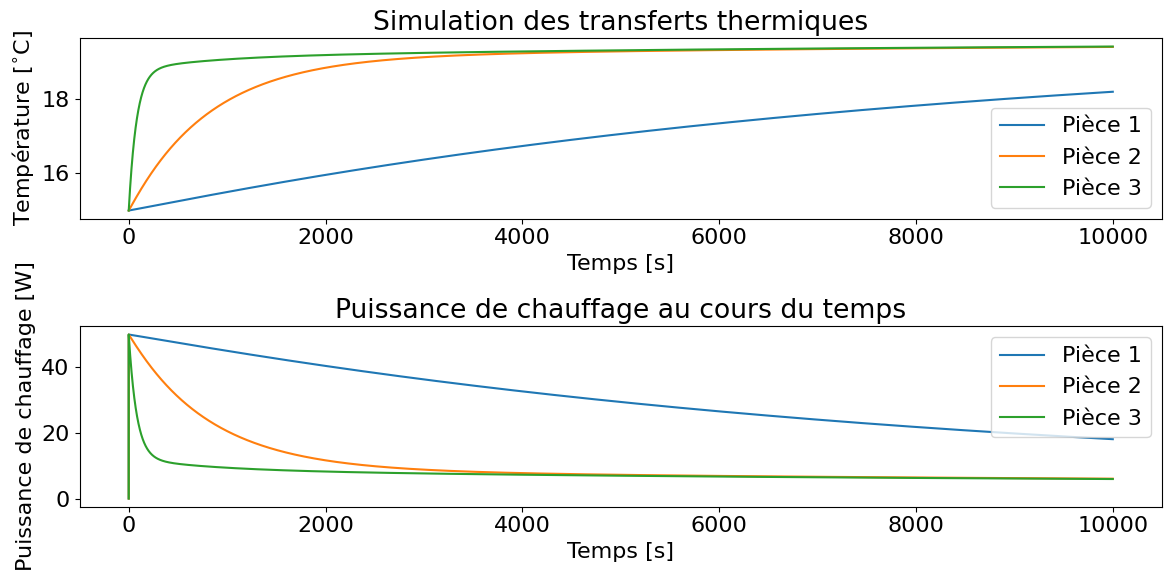

In [21]:

# Définir les paramètres
n_rooms = 3  # Nombre de pièces
C = np.diag([1.0e5, 1.0e4, 1.0e3])  # Matrice de capacités thermiques (valeurs d'exemple)
L = np.array([[2.0, -1.0, -1.0], [-1.0, 2.0, -1.0], [-1.0, -1.0, 2.0]])  # Matrice de conductance thermique (valeurs d'exemple)
K_ext = np.diag([0.5, 0.5, 0.5])  # Matrice de conductance thermique externe (valeurs d'exemple)
T_cible = np.array([20.0, 20.0, 20.0]) # Températures ciblées.

# Définir la fonction de température extérieure (exemple : température extérieure constante)
def T_ext_fonction(t):
    return np.array([10.0, 10.0, 10.0])

# Définir la fonction de puissance de chauffage (exemple : contrôle proportionnel)
def P_fonction(t, T, T_target=T_cible):
    K_p = 10.0 # Modulation du terme "proportionnel". 10 est une valeur couramment utilisée pour ce genre de problème.
    return K_p * (T_target - T)

# Températures initiales.
T_0 = np.array([15.0, 15.0, 15.0])

# Temps d'intégration.
t_f = 10000
t = np.linspace(0, t_f, int(t_f*10))

# Utilisation de la fonction modifiée
T, P = simule_modele_thermique(C, L, K_ext, T_ext_fonction, P_fonction, T_0, t)

# Afficher les résultats
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, T)
plt.xlabel("Temps [s]")
plt.ylabel(r"Température [$^{\circ}$C]")
plt.legend(["Pièce 1", "Pièce 2", "Pièce 3"])
plt.title('Simulation des transferts thermiques')

plt.subplot(2, 1, 2)
plt.plot(t, P)
plt.xlabel("Temps [s]")
plt.ylabel("Puissance de chauffage [W]")
plt.legend(["Pièce 1", "Pièce 2", "Pièce 3"])
plt.title('Puissance de chauffage au cours du temps')

plt.tight_layout()
plt.show()


In [22]:
# Calculer l'énergie totale de chauffage pour chaque pièce
E = np.trapz(P, t, axis=0)

# Afficher les résultats
for i in range(n_rooms):
    print(f"Énergie totale de chauffage pour la pièce {i+1} : {E[i]:.2f} J")

Énergie totale de chauffage pour la pièce 1 : 309905.02 J
Énergie totale de chauffage pour la pièce 2 : 106096.79 J
Énergie totale de chauffage pour la pièce 3 : 76804.51 J


# 3.3 Modèle d'activité neuronale
---

Avec des modèles simples de dynamique non linéaire, pouvons-nous aspirer obtenir un portrait d'activité qui colle à la structure déduite d'une observation au microscope?

* Modèle de Kuramoto : apte à reproduire l'activité "régionale" du cerveau.

On pourrait carrément feed un SC issu du poisson-zèbre par compilation des connexions neuronales dans le modèle dynamique et voir à quel point il y a ressemblance? Pour ce faire, on met sur pied une méthode de moyennage sur plusieurs simulations afin d'en explorer son espace de possibilités (systèmes chaotiques présentent des trajectoires imprévisibles).

Reconstruction d'un graphique de la corrélation SC/FC-simul selon le couplage.

Conclusion : permet de guider les études en neurosciences en suggérant que le cerveau biologique roule à un régime au "seuil du chaos". (edge of chaos).

D'autres modèles intéressants :
* Modèle theta : apte à reproduire l'activité d'un neurone individuel (QIF)
* Wilson-Cowan : à taux de décharge.

Sujet en plein développement, afin de diminuer l'empreinte des modèles d'apprentissage machine.

# 4. Conclusion : Et si les simulations apprenaient d'elles-mêmes ?

Nous avons illustré au moyen de trois exemples en quoi les simulations numériques permettent de modéliser des systèmes complexes en physique. Mais que se passerait-il si, au lieu de coder explicitement chaque interaction, on laissait un modèle apprendre ces dynamiques?

C’est là qu’interviennent les réseaux neuronaux entraînés sur des modèles physiques. Plutôt que d’évaluer chaque équation pas à pas, on entraîne un réseau sur des données simulées. Une fois entraîné, le réseau tente de prédire l’évolution du système bien plus rapidement qu’une intégration numérique classique. 

En théorie, cette méthode est loin d'être farfelue, puisqu'on sait depuis 1989 [1] qu'un réseau neuronal peut agir à titre d'« approximateur universel » de toutes fonctions continues! Il est donc logique d'essayer de capturer la dynamique d'un système de cette manière.

Cette approche commence déjà à être utilisée pour accélérer les simulations en mécanique des fluides, en physique des matériaux, et même en cosmologie! <span style="color:red">sources</span>.


**Les PINNs : le bac à sable du futur**

Les simulations basées sur les équations (comme celles du présent atelier) sont complémentaires à celles basées sur l’apprentissage machine. En combinant la rigueur des modèles physiques avec la puissance des réseaux neuronaux, on ouvre la voie à des simulations 
1) plus rapides,
2) moins énergivores,
3) détenant la capacité de généraliser sur de nouveaux cas.
   
On parle alors de « réseaux de neurones informés par la physique », ou PINNs (*Physics-informed neural networks*) en anglais. <span style="color:red">sources</span>

# 5. Références

[1] G. Cybenko, “Approximation by superpositions of a sigmoidal function,” Math. Control Signal Systems, vol. 2, no. 4, pp. 303–314, Dec. 1989, doi: 10.1007/BF02551274.

[2] “Loi de refroidissement de Newton,” Wikipédia. Jul. 29, 2023. Accessed: Mar. 02, 2025. [Online]. Available: https://fr.wikipedia.org/w/index.php?title=Loi_de_refroidissement_de_Newton&oldid=206457504

[3] “Matrice laplacienne,” Wikipédia. Sep. 15, 2024. Accessed: Mar. 02, 2025. [Online]. Available: https://fr.wikipedia.org/w/index.php?title=Matrice_laplacienne&oldid=218663112

[4] E. W. Weisstein, “Positive Definite Matrix.” Accessed: Mar. 02, 2025. [Online]. Available: https://mathworld.wolfram.com/PositiveDefiniteMatrix.html

[5] R. Axelrod and W. D. Hamilton, “The evolution of cooperation,” Science, vol. 211, no. 4489, pp. 1390–1396, Mar. 1981, doi: 10.1126/science.7466396.

[6] “Thermal conduction,” Wikipedia. Feb. 25, 2025. Accessed: Mar. 02, 2025. [Online]. Available: https://en.wikipedia.org/w/index.php?title=Thermal_conduction&oldid=1277574658

[7] I. Newton, “VII. Scala graduum caloris,” in Philosophical Transactions of the Royal Society of London, vol. 22, The Royal Society, 1701, pp. 824–829. doi: 10.1098/rstl.1700.0082.

[8] Veritasium, What Game Theory Reveals About Life, The Universe, and Everything, (2023). Accessed: Mar. 03, 2025. [Online Video]. Available: https://www.youtube.com/watch?v=mScpHTIi-kM




# ANNEXES
---

## Annexe A

### Recette : Comment réussir (ou pas) une simulation numérique

1. **Trouver un problème :** arroser les fleurs du tapis de la curiosité intellectuelle.
2. **Mathématiser le problème :** *soit un boeuf sphérique précédé d'une charrue...*
3. **Choisir des paramètres plausibles :** [*Itération 1*] partons à la cueillette de cerises, sans vergogne.
4. **Planifier une belle architecture** de code (digne du brutalisme, avec juste ce qu'il faut de chaos).
5. **Coder**, c’est-à-dire s'adonner à la chasse aux *bugs* en écoutant du [Georges Brassens](https://www.youtube.com/watch?v=oOPBnbNxLDM).
6. **Visualiser les résultats** (et ajuster les couleurs pour que ça ait l’air crédible).

À la lumière des résultats, l'on peut juger de l'aptitude du modèle à bien décrire le phénomène. Des incréments en complexité peuvent alors être rajoutés si l'on juge que c'est nécessaire.

## Annexe B : Autres exemples de simulation
### Simulateur écologique
<img src="inc/simul_chaos_lapino.png" width=600 height=600 />
<img src="inc/simul_chaos_carte.png" width=600 height=600 />

## Annexe C : Dynamique de "relaxation" des températures en l'absence des radiateurs
Soit l'équation du système thermique sans radiateur
$$
C\frac{\text{d}\mathbf{T}(t)}{\text{d}t} = -L\mathbf{T}(t) \Longleftrightarrow \frac{\text{d}\mathbf{T}(t)}{\text{d}t} = -C^{-1}L\mathbf{T}(t).
$$
On suppose que la quantité matricielle $C^{-1}L$ est diagonalisable de manière à ce que $C^{-1}L = S\Lambda S{-1}$. Ainsi,
$$
\frac{\text{d}\mathbf{T}(t)}{\text{d}t} = -S\Lambda S^{-1}\mathbf{T}(t).
$$
En prenant $\tilde{\mathbf{T}}(t) = S{-1}\mathbf{T}$, l'équation se diagonalise, ce qui découple les $N$ équations sous-jacentes. On obtient alors
$$
S^{-1}\frac{\text{d}\mathbf{T}(t)}{\text{d}t} = -\Lambda S^{-1}\mathbf{T}(t) \implies \frac{\text{d}\tilde{\mathbf{T}}(t)(t)}{\text{d}t} = -\Lambda \tilde{\mathbf{T}}(t).
$$
Cette forme est directement intégrable. En posant $\mathbf{T}_0 \equiv \mathbf{T}(0)$ comme conditions initiales, sa solution va comme
$$
\tilde{\mathbf{T}}(t) = \exp{-\Lambda t} \tilde{\mathbf{T}}_0.
$$
Ceci met en évidence que, dans l'*espace propre* de $C^{-1} L$, les températures sont vouées à la décroissance exponentielle. En effet, la matrice $C^{-1}$ étant diagonale et positive, son produit par $L$ ne sort pas les valeurs propres (réelles) de la positivité.
